In [1]:
# Importing the important libraries for the project
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import plotly.express as px

warnings.filterwarnings('ignore')
%matplotlib inline


##  Table of Contents

- [1. Data Preprocessing](#1-data-preprocessing)
  - [1.1 Data Overview](#11-data-overview)
  - [1.2 Final Dataset Schema](#12-model-ready-data-schema)
  - [1.3 Data Cleaning and Preparation](#13-data-cleaning-and-preparation)
- [2. Analysis and Visualization](#2-analysis-and-visualization)
- [3. Correlation Study](#3-correlation-study)
- [4. Key Findings & Interpretations](#4-key-findings--interpretation-of-the-heatmap)


In [2]:
# import the data
data_wth = pd.read_csv("data/raw/weather_data.csv")
data_poll = pd.read_csv("data/raw/pollution_2000_2023.csv")
pm10 = pd.read_csv("data/raw/pm10.csv")
pm25 = pd.read_csv("data/raw/pm25.csv")

# 1. Data Preprocessing

## 1.1 Data Overview

In [33]:
(
    pm10.columns.values,
    pm10.shape,
), (
    data_wth.columns.values,
    data_wth.shape,
), (data_poll.columns, data_poll.shape)

((array(['Date', 'Source', 'Site ID', 'POC',
         'Daily Mean PM10 Concentration', 'Units', 'Daily AQI Value',
         'Local Site Name', 'Daily Obs Count', 'Percent Complete',
         'AQS Parameter Code', 'AQS Parameter Description', 'Method Code',
         'CBSA Code', 'CBSA Name', 'State FIPS Code', 'State',
         'County FIPS Code', 'County', 'Site Latitude', 'Site Longitude'],
        dtype=object),
  (4134, 21)),
 (array(['STATION', 'NAME', 'LATITUDE', 'LONGITUDE', 'ELEVATION', 'DATE',
         'AWND', 'PRCP', 'SNOW', 'SNWD', 'TAVG', 'TMAX', 'TMIN', 'TOBS',
         'WT01', 'WT02', 'WT03', 'WT04', 'WT05', 'WT06', 'WT07', 'WT08',
         'WT10', 'WT11', 'WT13', 'WT14', 'WT16', 'WT18', 'WT19', 'WT21',
         'WT22'], dtype=object),
  (314376, 31)),
 (Index(['Unnamed: 0', 'Date', 'Address', 'State', 'County', 'City', 'O3 Mean',
         'O3 1st Max Value', 'O3 1st Max Hour', 'O3 AQI', 'CO Mean',
         'CO 1st Max Value', 'CO 1st Max Hour', 'CO AQI', 'SO2 Mean',
     

==================== DATA PREPARATION OVERVIEW ====================

**Goal:**  
Create a clean, daily-level dataset (2012–2023) for Los Angeles that combines air pollutants (O₃, CO, SO₂, NO₂), PM2.5/PM10, corresponding AQI values, weather variables (wind, precipitation, temperature), and temporal context (year, month, season).  

They are cleaned for statistical analysis and  machine learning study.


### Data Sources and Descriptions

1. **pm10 & PM2.5**: Contains daily PM_X (particulate matter) concentration data:  
   - Source: U.S. Environmental Protection Agency (EPA) Air Quality System (AQS) 
      - Link: https://www.epa.gov/outdoor-air-quality-data/download-daily-data
   - Temporal coverage: Daily  
   - Data Shape: (4134, 21) 

2. **data_wth**: Contains daily weather observations from meteorological stations:  
   - Source: National Centers for Environmental Information (NCEI) 
      - Link: https://www.ncei.noaa.gov/cdo-web/datasets 
   - Temporal coverage: Daily  
   - Data Shape: (314376, 31)

3. **data_poll**: Contains ground-level air pollutant concentration data and corresponding AQI values:
   - Source: From 2000-2016 (https://www.kaggle.com/datasets/sogun3/uspollution/data) and from 2016 - 2023 they were obtained from multiple resources.   
   - Temporal coverage: Daily measurements  
   - Data Shape: (665414, 22)  


These datasets will be cleaned, spatially filtered, and aggregated to daily averages.
Finally, they will be merged based on the 'Date' column to produce a consistent and analysis-ready dataset.

--- 

### **Schema of the original datasets**

### daily PM10 & PM2.5
| pm10        |                                          |                                                  |
|-------------|------------------------------------------|--------------------------------------------------|
|             | Daily Mean PM10 Concentration            | PM10 measurement (µg/m³)                         |
|             | Daily AQI Value                          | AQI for PM10                                     |
|             | Site Latitude, Site Longitude            | Monitoring station coordinates                   |
|             | Site ID, Source, POC                     |  identifiers for the monitoring site    |
|             | Units, Local Site Name                   |                                                  |
|             | Daily Obs Count, Percent Complete        |                        |
|             | Method Code, AQS Parameter Description   |             |
|             | CBSA Code, CBSA Name                     |                |
|             | State FIPS Code, County FIPS Code        |                                                  |


### Weather observations from meteorological stations
| data_wth    |                                          | Station identifiers                              |
|-------------|------------------------------------------|--------------------------------------------------|
|             | LATITUDE, LONGITUDE, ELEVATION           | Geolocation and altitude                         |
|             | DATE                                     | Observation date                                 |
|             | AWND, PRCP, TAVG, TMAX, TMIN             | Weather features: wind, precipitation, temp      |
|             | SNOW, SNWD, TOBS                         | Snow and observed temperature data               |
|             | WT01–WT22                                | |




##### Pollutant concentration data
| data_poll   |                                          | Description                                      |
|-------------|------------------------------------------|--------------------------------------------------|
|             | Date                                     | Observation date                                 |
|             | Address, State, County, City            | Location metadata                                |
|             | O3 Mean, CO Mean, SO2 Mean, NO2 Mean     | Mean daily concentrations of pollutants          |
|             | O3 AQI, CO AQI, SO2 AQI, NO2 AQI         | Corresponding Air Quality Index values           |
|             | O3 1st Max Value, CO 1st Max Value, etc. |       |
|             | O3 1st Max Hour, etc.                    |              |



## 1.2 Model-Ready Data Schema


The goal is to clean and filter the above data to produce a unified daily dataset for **Los Angeles**, containing the following variables:

| Column                                 | Description                                   |
|---------------------------------------|-----------------------------------------------|
| `O3`                                  | Daily mean ozone concentration (ppm)          |
| `CO`                                  | Daily mean carbon monoxide (ppm)              |
| `SO2`                                 | Daily mean sulfur dioxide (ppb)               |
| `NO2`                                 | Daily mean nitrogen dioxide (ppb)             |
| `O3 AQI`, `CO AQI`, `SO2 AQI`, `NO2 AQI` | AQI values corresponding to O₃, CO, SO₂, NO₂ respectively |
| `PM2.5`                               | Daily mean PM2.5 concentration (µg/m³)        |
| `PM10`                                | Daily mean PM10 concentration (µg/m³)         |
| `AWND`                                | Average wind speed (mph)               |
| `PRCP`                                | Total precipitation (inches)            |
| `TAVG`                                | Daily average temperature (°C)          |
| `year`                                | Year extracted from the date                  |
| `month`                               | Month extracted from the date (1–12)          |
| `season`                              | Meteorological season (e.g., Winter, Summer)  |


## 1.3 Data Cleaning and Preparation

#### Preparing data

In [3]:
# import clean_data function from data_cleaning.py
from utils.clean_data import apply_data_cleaning

# ==============PM  Processing==============================

# ==================== Spatial Filtering ====================
# Filter PM10 and PM2.5 datasets to include only monitoring sites within a specific geographic reigon
# covering the target study region (e.g., Southern California),
# I found that the Latitude range for Los Angeles is: [33.5, 34.8], Longitude range: [-119.0, -117.5]
pm10 = pm10[
    (pm10["Site Latitude"] >= 33.5)
    & (pm10["Site Latitude"] <= 34.8)
    & (pm10["Site Longitude"] >= -119.0)
    & (pm10["Site Longitude"] <= -117.5)
]
pm25 = pm25[
    (pm25["Site Latitude"] >= 33.5)
    & (pm25["Site Latitude"] <= 34.8)
    & (pm25["Site Longitude"] >= -119.0)
    & (pm25["Site Longitude"] <= -117.5)
]


# ==================== Temporal Aggregation ====================
# Clean and aggregate PM10 data to daily means over the period 2012–2023
pm10 = apply_data_cleaning(
    pm10,
    "aggregate_to_daily_mean",
    date_column="Date",
    aggregate_by=["Date"],
    columns_to_aggregate=["Daily Mean PM10 Concentration"],
    start_year="2012-01-01",
    end_year="2023-01-01",
)

pm25 = apply_data_cleaning(
    pm25,
    "aggregate_to_daily_mean",
    date_column="Date",
    aggregate_by=["Date"],
    columns_to_aggregate=["Daily Mean PM2.5 Concentration"],
    start_year="2012-01-01",
    end_year="2023-01-01",
)


# ==================== Merging and Formatting ====================
# Merge PM2.5 and PM10 datasets on the "Date" column using an inner join to retain common dates only
data_pm = pd.merge(
    pm25, pm10[["Date", "Daily Mean PM10 Concentration"]], on="Date", how="inner"
)

# Select and rename relevant columns for final dataset
data_pm = data_pm[
    ["Date", "Daily Mean PM2.5 Concentration", "Daily Mean PM10 Concentration"]
]
data_pm.rename(columns={"Daily Mean PM2.5 Concentration": "PM2.5"}, inplace=True)
data_pm.rename(columns={"Daily Mean PM10 Concentration": "PM10"}, inplace=True)

In [35]:
data_pm.head()

,Date,PM2.5,PM10
0,2013-01-01,30.416667,15.0
1,2013-01-02,11.541667,10.0
2,2013-01-03,13.446154,17.0
3,2013-01-04,12.036364,23.0
4,2013-01-05,20.546154,21.0


In [36]:
# ==================== wth_data Processing ====================

# Filter weather data to include only stations within the target geographical bounds (LA):
# Latitude: [33.5, 34.8], Longitude: [-119.0, -117.5]
data_wth = data_wth[
    (data_wth["LATITUDE"] >= 33.5)
    & (data_wth["LATITUDE"] <= 34.8)
    & (data_wth["LONGITUDE"] >= -119.0)
    & (data_wth["LONGITUDE"] <= -117.5)
]


# Clean and aggregate weather data to daily means
# Aggregated variables: Average wind speed (AWND), precipitation (PRCP), average temperature (TAVG)
data_wth = apply_data_cleaning(
    data_wth,
    function_name="aggregate_to_daily_mean",
    date_column="DATE",
    aggregate_by=["DATE"],
    columns_to_aggregate=["AWND", "PRCP", "TAVG"],
    start_year="2012-01-01",
    end_year="2023-01-01",
)

data_wth.rename(columns={"DATE": "Date"}, inplace=True)

In [37]:
data_wth.head()

,Date,AWND,PRCP,TAVG
0,2012-01-01,4.788,0.000789,60.368421
1,2012-01-02,4.026,0.000500,61.736842
2,2012-01-03,2.550,0.000000,62.842105
3,2012-01-04,4.025,0.000000,63.315789
4,2012-01-05,3.444,0.000000,63.000000


In [38]:
# ================data_poll Processing==========================
data_poll_LA = data_poll[data_poll["County"] == "Los Angeles"]
columns_to_aggregate = [
    "O3 Mean",
    "CO Mean",
    "SO2 Mean",
    "NO2 Mean",
    "O3 AQI",
    "CO AQI",
    "SO2 AQI",
    "NO2 AQI",
]
data_poll = apply_data_cleaning(
    data_poll_LA,
    function_name="aggregate_to_daily_mean",
    date_column="Date",
    aggregate_by=["Date"],
    columns_to_aggregate=columns_to_aggregate,
    start_year="2012-01-01",
    end_year="2023-01-01",
)

# Rename
data_poll.rename(columns={"O3 Mean": "O3"}, inplace=True)
data_poll.rename(columns={"CO Mean": "CO"}, inplace=True)
data_poll.rename(columns={"SO2 Mean": "SO2"}, inplace=True)
data_poll.rename(columns={"NO2 Mean": "NO2"}, inplace=True)

In [40]:
data_poll.head()

,Date,O3,CO,SO2,NO2,O3 AQI,CO AQI,SO2 AQI,NO2 AQI
0,2012-01-01,0.014741,0.779739,0.573953,27.300712,24.2,14.80,1.6,43.8
1,2012-01-02,0.010977,0.605000,0.689131,23.764032,21.0,10.60,2.8,36.2
2,2012-01-03,0.005235,1.002500,1.365454,35.250909,10.6,17.20,3.8,47.6
3,2012-01-04,0.004162,1.127250,0.967368,34.364274,9.8,18.20,3.0,46.2
4,2012-01-05,0.005710,0.931007,1.110718,33.723115,13.5,15.75,3.0,44.0


In [41]:
# check empty data
data_wth.isnull().sum(), data_poll.isnull().sum(), data_pm.isnull().sum()

(Date    0
 AWND    0
 PRCP    0
 TAVG    0
 dtype: int64,
 Date       0
 O3         0
 CO         0
 SO2        0
 NO2        0
 O3 AQI     0
 CO AQI     0
 SO2 AQI    0
 NO2 AQI    0
 dtype: int64,
 Date     0
 PM2.5    0
 PM10     0
 dtype: int64)

##### Merging Data

In [42]:
data_poll.columns, data_wth.columns.values, data_pm.columns.values

(Index(['Date', 'O3', 'CO', 'SO2', 'NO2', 'O3 AQI', 'CO AQI', 'SO2 AQI',
        'NO2 AQI'],
       dtype='object'),
 array(['Date', 'AWND', 'PRCP', 'TAVG'], dtype=object),
 array(['Date', 'PM2.5', 'PM10'], dtype=object))

In [43]:
data_poll.set_index("Date", inplace=True)
data_pm.set_index("Date", inplace=True)
data_wth.set_index("Date", inplace=True)

# Merge the first two data frames on index
df1 = data_poll.join(data_pm, how="inner")
# Merge the second two data frames on index
df = df1.join(data_wth, how="inner")

# Adding year, month, and season column
df = apply_data_cleaning(
    df, "add_date_columns", date_column="Index", columns=["year", "month", "season"]
)

In [44]:
print(f"The final data shape is: {df.shape}")
df.head()

The final data shape is: (3527, 16)


,O3,CO,SO2,NO2,O3 AQI,CO AQI,SO2 AQI,NO2 AQI,PM2.5,PM10,AWND,PRCP,TAVG,year,month,season
Date,,,,,,,,,,,,,,,,
2013-01-01,0.014167,0.893596,0.360079,24.505177,26.333333,19.166667,0.666667,35.666667,30.416667,15.0,4.584,0.000000,42.380952,2013,1,Winter
2013-01-02,0.012020,1.073611,0.894038,34.154414,22.333333,16.166667,5.000000,46.000000,11.541667,10.0,5.481,0.000000,47.571429,2013,1,Winter
2013-01-03,0.011734,1.243333,0.952253,37.843584,20.600000,19.200000,2.000000,47.200000,13.446154,17.0,5.414,0.000185,48.904762,2013,1,Winter
2013-01-04,0.012165,1.084722,0.799386,35.727058,22.200000,17.200000,1.800000,42.200000,12.036364,23.0,3.424,0.000000,47.809524,2013,1,Winter
2013-01-05,0.012682,1.225833,0.783083,33.455402,20.000000,20.400000,2.000000,43.200000,20.546154,21.0,2.617,0.001698,47.285714,2013,1,Winter


In [45]:
# check any nulls:
df.isnull().sum()

O3         0
CO         0
SO2        0
NO2        0
O3 AQI     0
CO AQI     0
SO2 AQI    0
NO2 AQI    0
PM2.5      0
PM10       0
AWND       0
PRCP       0
TAVG       0
year       0
month      0
season     0
dtype: int64

In [46]:
# remove any rows with either negative or zero features
df = apply_data_cleaning(df, "remove_negatives")

The number of removed rows is: 32


#### remove outliers

In [47]:
df0 = df
df = apply_data_cleaning(
    df,
    "remove_outliers",
    columns=["PM2.5", "PM10", "TAVG", "O3", "SO2", "CO", "NO2", "AWND"],
    threshold=3,
)
df0.shape, df.shape

Removed 57 rows due to outliers in column 'PM2.5'
Removed 42 rows due to outliers in column 'PM10'
Removed 0 rows due to outliers in column 'TAVG'
Removed 2 rows due to outliers in column 'O3'
Removed 31 rows due to outliers in column 'SO2'
Removed 42 rows due to outliers in column 'CO'
Removed 10 rows due to outliers in column 'NO2'
Removed 29 rows due to outliers in column 'AWND'


((3495, 16), (3282, 16))

In [48]:
# Convert TAVG from F to C:
df["TAVG"] = (df["TAVG"] - 32) * 5 / 9

In [ ]:
# save
df.to_csv("data/processed/df_main.csv", index=True)

# 2. Analysis and Visualization

#### Temperature

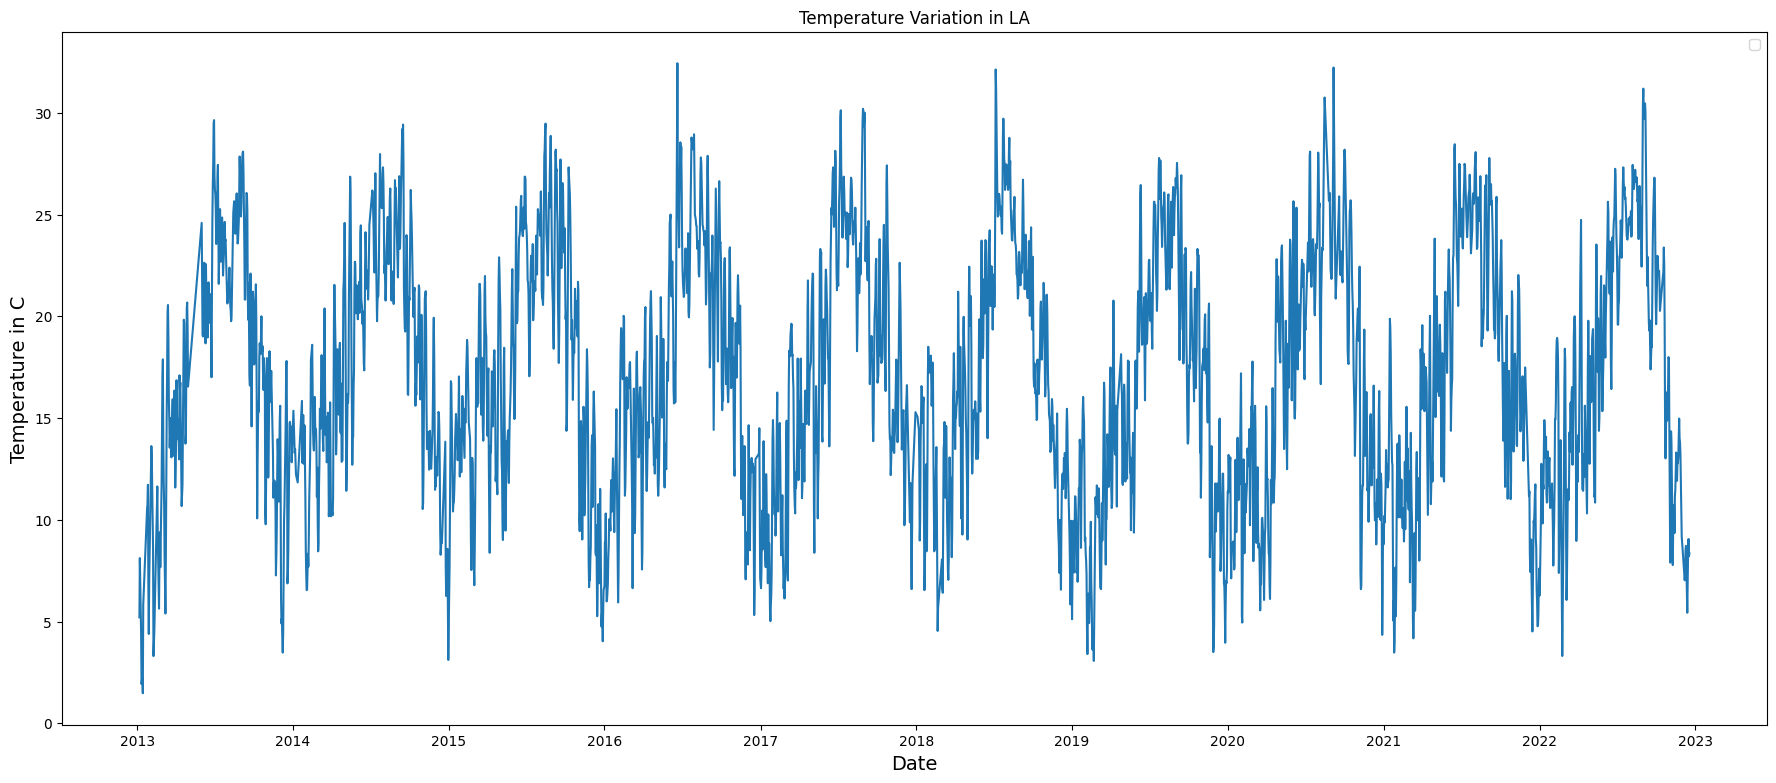

In [4]:
df = pd.read_csv("data/processed/df_main.csv")
df["Date"] = pd.to_datetime(df["Date"])
df.set_index("Date", inplace=True)

plt.figure(figsize=(22, 9))
sns.lineplot(x=df.index, y=df["TAVG"])
plt.title("Temperature Variation in LA")
plt.xlabel("Date", fontsize=14)
plt.ylabel("Temperature in C", fontsize=14)
plt.legend()
plt.show()

In [60]:
# Group by 'month' and calculate the average Temperature for each month over the years 2013-2022
monthly_T = df.groupby("month")["TAVG"].mean().reset_index()

fig = px.bar(
    monthly_T,
    x="month",
    y=["TAVG"],
    title="Average Temperature by Month",
    barmode="group",
)

fig.update_layout(yaxis_title="Temperature (°C)", xaxis_title="Month")


fig.show()

# Group by 'season' and calculate the average Temperature for each season over the years 2013-2022
seasonal_T = df.groupby("season")["TAVG"].mean().reset_index()

# Define ordered season names with month labels
season_labels = {
    "Winter": "Winter (Dec–Feb)",
    "Spring": "Spring (Mar–May)",
    "Summer": "Summer (Jun–Aug)",
    "Fall": "Fall (Sep–Nov)",
}

seasonal_T["season"] = seasonal_T["season"].map(season_labels)

fig = px.bar(
    seasonal_T,
    x="season",
    y=["TAVG"],
    title="Average Temperature by Season",
    barmode="group",
)

fig.update_layout(
    yaxis_title="Temperature (°C)", xaxis_title="Season (with corresponding months)"
)


fig.show()

### Los Angeles Temperature (in Celsius)

- **Warmest Months (July–September):**  
  - **Average High:** ~28.5 °C  
  - **Average Low:** ~18.5 °C

- **Coolest Months (December–February):**  
  - **Average High:** ~20 °C  
  - **Average Low:** ~9.5 °C

Which is approximately consistent with our data above. These figures indicate that summer is the warmest season, followed by fall, spring, and winter.

**Reference:**  
Climate normals for Los Angeles based on NOAA 1991–2020 data, available at [NOAA National Centers for Environmental Information](https://www.ncei.noaa.gov/).


#### TAVG with other main features PM2.5, PM10, & AWND

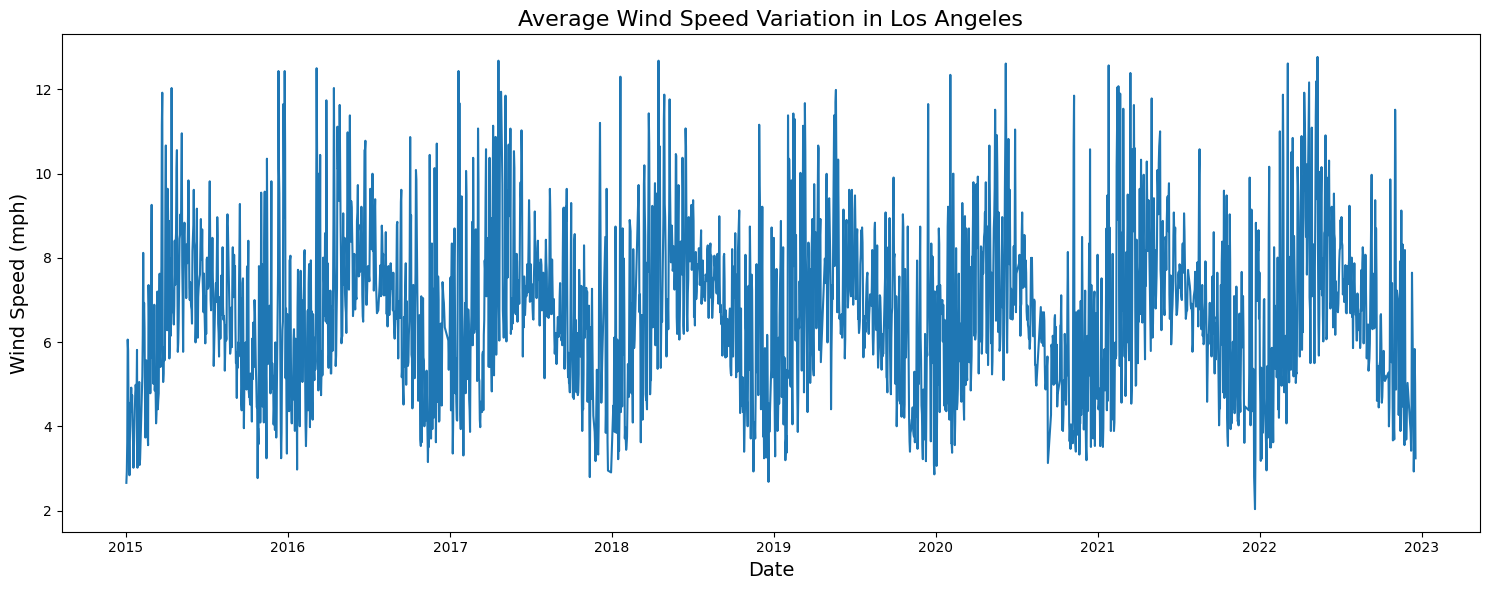

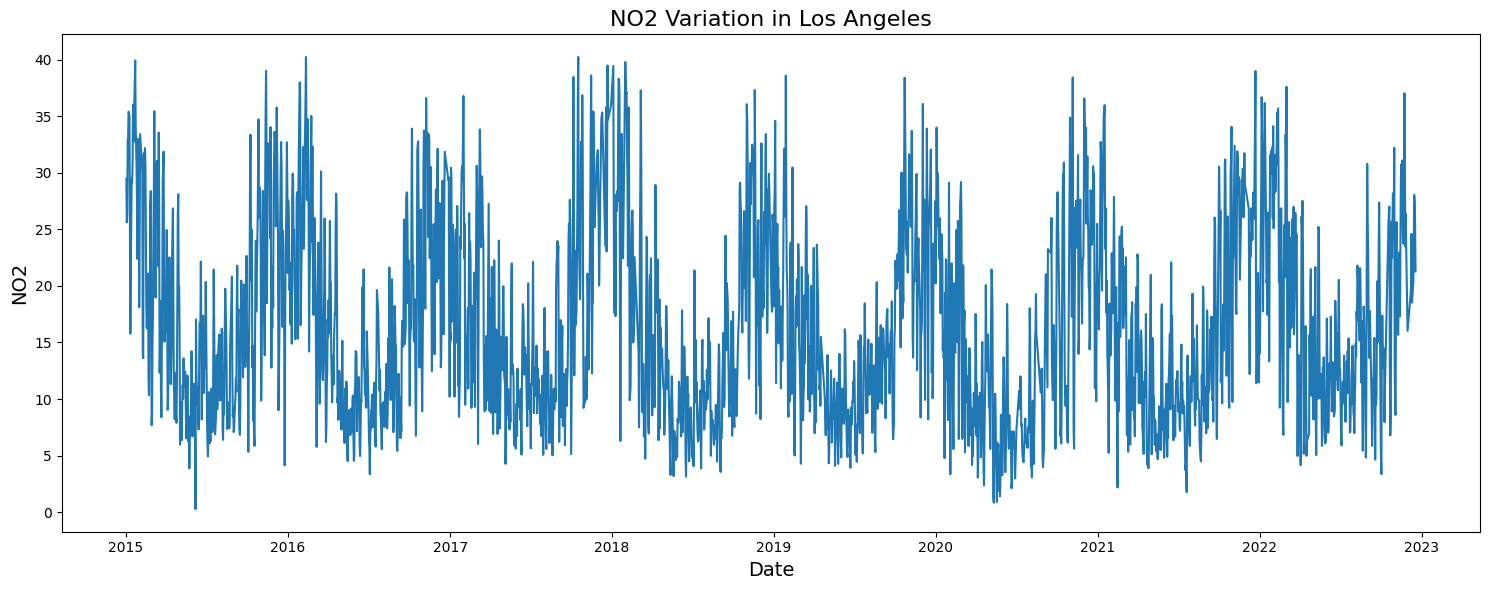

In [61]:
plt.figure(figsize=(15, 6))
df_5yr = df[(df["year"] >= 2015)]
sns.lineplot(x=df_5yr.index, y=df_5yr["AWND"], markers="-o")
plt.title("Average Wind Speed Variation in Los Angeles", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Wind Speed (mph)", fontsize=14)
plt.tight_layout()

plt.show()

plt.figure(figsize=(15, 6))
df_5yr = df[(df["year"] >= 2015)]
sns.lineplot(x=df_5yr.index, y=df_5yr["NO2"], markers="-o")
plt.title("NO2 Variation in Los Angeles", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("NO2", fontsize=14)
plt.tight_layout()

In [62]:
# Define ordered season names with month labels
season_labels = {
    "Winter": "Winter (Dec–Feb)",
    "Spring": "Spring (Mar–May)",
    "Summer": "Summer (Jun–Aug)",
    "Fall": "Fall (Sep–Nov)",
}

# Define season order
season_order = ["Winter", "Spring", "Summer", "Fall"]

# Set 'season' as ordered categorical
df["season"] = pd.Categorical(df["season"], categories=season_order, ordered=True)

# Group by season and compute means
seasonal_stats = (
    df.groupby("season")[["TAVG", "PM2.5", "PM10", "AWND"]].mean().reset_index()
)

# Replace season names with labels
seasonal_stats["season"] = seasonal_stats["season"].map(season_labels)


# Multiply AWND by the constant
seasonal_stats["AWND"] = seasonal_stats["AWND"] * 2.5

# Plot
fig = px.bar(
    seasonal_stats,
    x="season",
    y=["TAVG", "PM2.5", "PM10", "AWND"],
    title="Average Temperature, PM2.5, PM10, & AWND by Season",
    barmode="group",
)

fig.update_layout(xaxis_title="Season (with corresponding months)", yaxis_title="Value")

fig.show()

> The above graph indicates that PM10 peak at certain seasons (Summer-Fall) in contrast to PM2.5 which minimally change.



# 3. Correlation Study

### Pearson Correlation and Relationship Between Variables

We use the **Pearson Correlation Coefficient** to measure how strongly two variables are related. Specifically, it tells us:

- **How much they change together** (covariance),
- Relative to **how much they vary on their own** (standard deviation).

This gives a value between **–1 and +1**:
- **+1**: perfect positive linear relationship
- **0**: no linear relationship
- **–1**: perfect negative linear relationship

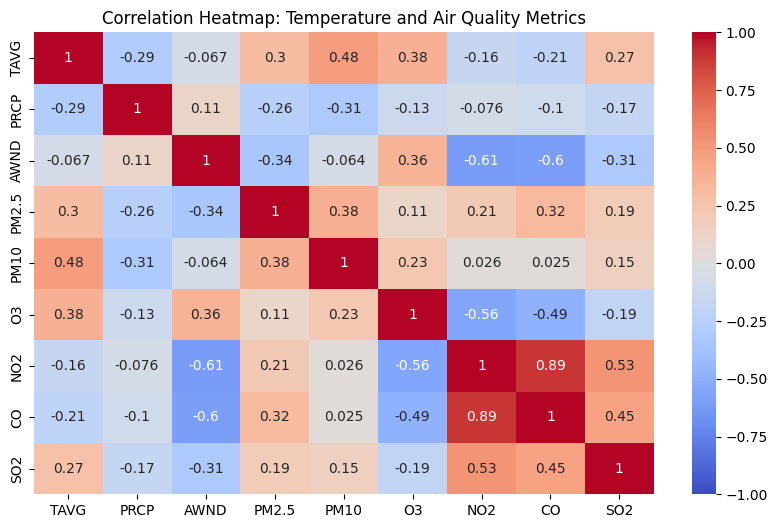

In [25]:
# Correlation heatmap
corr = df[["TAVG", "PRCP", "AWND", "PM2.5", "PM10", "O3", "NO2", "CO", "SO2"]].corr(
    method="pearson"
)
plt.figure(figsize=(10, 6))
sns.heatmap(corr, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Heatmap: Temperature and Air Quality Metrics")
plt.show()

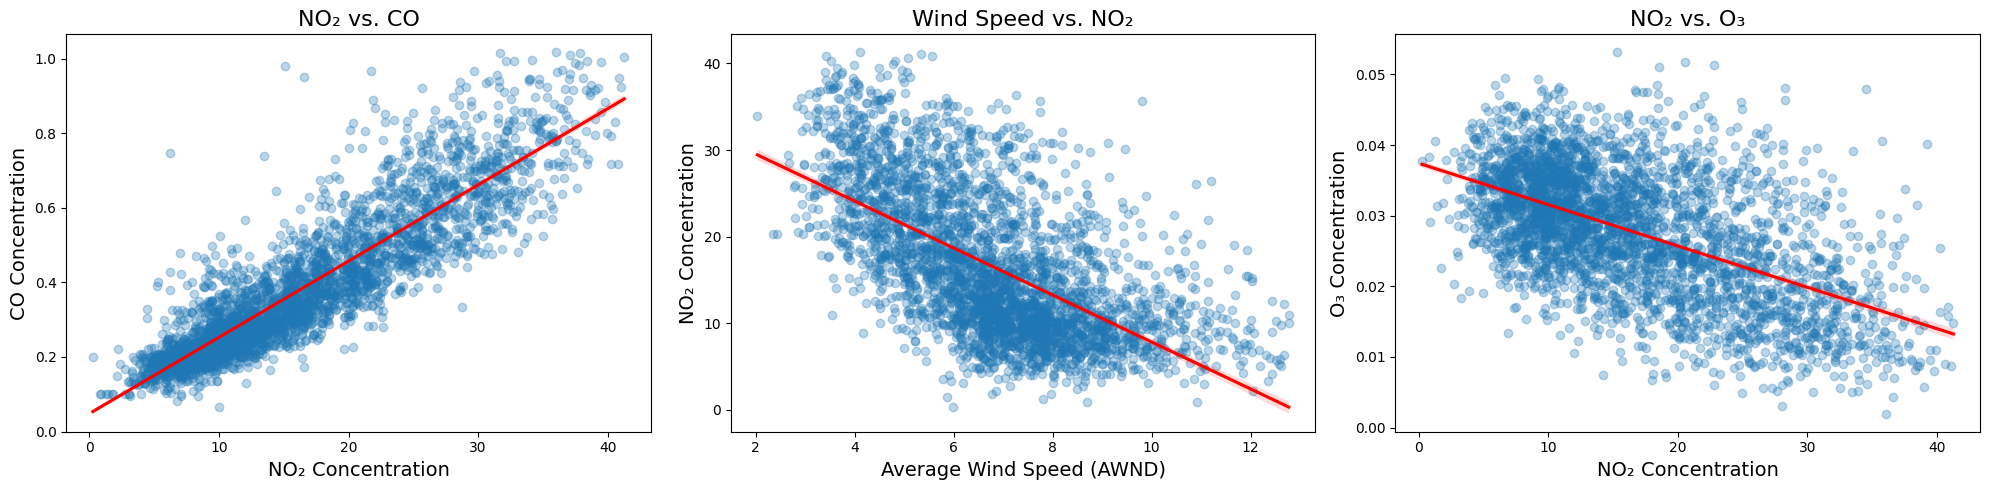

In [67]:
# Set up figure and axes: 1 row, 3 columns
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

# Font size settings
title_fontsize = 16
label_fontsize = 14

# 1. NO2 vs CO
sns.regplot(
    x="NO2",
    y="CO",
    data=df,
    scatter_kws={"alpha": 0.3},
    line_kws={"color": "red"},
    ax=axs[0],
)
axs[0].set_title("NO₂ vs. CO", fontsize=title_fontsize)
axs[0].set_xlabel("NO₂ Concentration", fontsize=label_fontsize)
axs[0].set_ylabel("CO Concentration", fontsize=label_fontsize)

# 2. AWND vs NO2
sns.regplot(
    x="AWND",
    y="NO2",
    data=df,
    scatter_kws={"alpha": 0.3},
    line_kws={"color": "red"},
    ax=axs[1],
)
axs[1].set_title("Wind Speed vs. NO₂", fontsize=title_fontsize)
axs[1].set_xlabel("Average Wind Speed (AWND)", fontsize=label_fontsize)
axs[1].set_ylabel("NO₂ Concentration", fontsize=label_fontsize)

# 3. NO2 vs O3
sns.regplot(
    x="NO2",
    y="O3",
    data=df,
    scatter_kws={"alpha": 0.3},
    line_kws={"color": "red"},
    ax=axs[2],
)
axs[2].set_title("NO₂ vs. O₃", fontsize=title_fontsize)
axs[2].set_xlabel("NO₂ Concentration", fontsize=label_fontsize)
axs[2].set_ylabel("O₃ Concentration", fontsize=label_fontsize)

plt.tight_layout()
plt.show()


# 4. Key Findings & Interpretation of the Heatmap

| **Variable Pair** | **Correlation** | **Strength & Interpretation**                            |
|-------------------|------------------|-----------------------------------------------------------|
| **NO2 – CO**      | **+0.89**        | Very strong positive correlation (shared emission sources) |
| **AWND – NO2**    | **–0.61**        | Strong negative correlation (wind disperses NO2)           |
| **AWND – CO**     | **–0.60**        | Strong negative correlation (wind disperses CO)            |
| **O3 – NO2**      | **–0.56**        | Strong negative correlation (NO2 scavenges ozone)          |
| **O3 – CO**       | **–0.49**        | Moderate-to-strong negative correlation                    |
| **TAVG – PM10**   | **+0.48**        | Moderate-to-strong positive correlation (temp ↔ dust/PM10) |
| **SO2 – NO2**     | **+0.53**        | Strong positive correlation (related pollution sources)    |




####  **1. Strong Coupling Between Combustion Pollutants (NO₂ and CO)**
- **Correlation:** +0.89
- **Implication:** NO₂ and CO are strongly correlated, indicating **common sources such as traffic and industrial combustion**. This confirms that **monitoring either can provide insights into general combustion-related pollution** in industrial zones.

####  **2. Wind Speed (AWND) Has a Major Dispersive Effect on Air Pollutants**
- **Correlations:**
  - AWND–NO₂: **–0.61**
  - AWND–CO: **–0.60**
  - AWND–PM2.5: **–0.34**
- **Implication:** Higher wind speeds are **consistently associated with reduced concentrations** of pollutants. This suggests that **wind acts as a natural ventilator**, and should be integrated into spatiotemporal pollutant dispersion models.

####  **3. Temperature Positively Influences Ozone and Particulate Levels**
- **Correlations:**
  - TAVG–O₃: **+0.38**
  - TAVG–PM10: **+0.48**
- **Implication:** Rising temperatures are associated with **increased ozone and coarse particulate levels**, reinforcing concerns about **climate change exacerbating air pollution** in heat-prone regions.

####  **4. Ozone Behavior is Inversely Related to Combustion Emissions**
- **Correlations:**
  - O₃–NO₂: **–0.56**
  - O₃–CO: **–0.49**
- **Implication:** **High NO₂ and CO levels suppress ozone concentrations**, likely due to chemical scavenging. This is critical when interpreting satellite-detected ozone concentrations in polluted environments.



